## Import

In [231]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Classification
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix #metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

In [232]:
#import data
df = pd.read_csv("train.csv")
df.shape

(1460, 81)

In [233]:
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

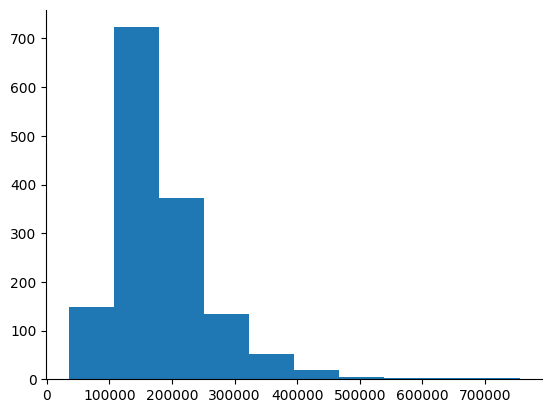

In [234]:
#Variable to predict
plt.hist(df["SalePrice"])
sns.despine()

In [235]:
#import data
df_test = pd.read_csv("test.csv")
df_test.shape

(1459, 80)

## Preprocessing

### Missing values

In [236]:
missing_percentages = (df.isna().sum() / len(df)) * 100
missing_percentages = missing_percentages[missing_percentages > 0].sort_values(ascending=False)
print(missing_percentages)

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
MasVnrType      59.726027
FireplaceQu     47.260274
LotFrontage     17.739726
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
BsmtFinType2     2.602740
BsmtExposure     2.602740
BsmtFinType1     2.534247
BsmtCond         2.534247
BsmtQual         2.534247
MasVnrArea       0.547945
Electrical       0.068493
dtype: float64


In [237]:
#Delete those with more than 10% of MV in the training set
def drop_lot_of_mv_var(df):
    df = df.drop(columns = ["PoolQC", "MiscFeature", 
                            "Alley", "Fence", "MasVnrType",
                            "FireplaceQu", "LotFrontage"])
    return df

In [238]:
df = drop_lot_of_mv_var(df)
df_test = drop_lot_of_mv_var(df_test)

In [240]:
#Impuute the reamining missing values

def impute_vars_mv(df):
    for variable in df.columns:
        column_dtype = df[variable].dtype
        if column_dtype == 'object': #if it is categorical fill with most common value
            most_common_value = df[variable].mode()[0]  # Calculate the mode
            df[variable].fillna(most_common_value, inplace=True)
        else: #if it is continuous fill with mean
            mean_value = df[variable].mean()  # Calculate the mean
            df[variable].fillna(mean_value, inplace=True)
    
    return df

In [241]:
df = impute_vars_mv(df)
df_test = impute_vars_mv(df_test)

In [242]:
#How many missing values are there still in the data? 
df.isna().sum().sum()

0

In [243]:
df_test.isna().sum().sum()

0

### Columns to drop

In [244]:
#data trasnformations - remove id as it is not usefull for regression
df = df.drop(columns = "Id")
df_test = df_test.drop(columns = "Id")

### Encoding variables

#### Categorical nominal variables - One Hot Encoding

In [247]:
categorical_nominal_variables = ["MSZoning", 
                                 "LandContour", 
                                 "Neighborhood", 
                                 "Condition1", 
                                 "Condition2", 
                                 "RoofStyle", 
                                 "RoofMatl",
                                 "Exterior1st",
                                 "Exterior2nd",
                                 "Foundation",
                                 "Heating",
                                 "SaleType",
                                 "SaleCondition", 
                                 "LotConfig", 
                                 "BldgType", 
                                 "HouseStyle",
                                 "GarageType"]

In [248]:
def one_hot_encode(df, variable):
    #Perform one-hot encoding with the correct prefix
    encoded_columns = pd.get_dummies(df[variable], prefix=variable).astype(int)
    #Join the encoded columns with the original DataFrame
    df = df.join(encoded_columns).drop(columns = variable)
    return df

In [249]:
def encode_cat_norminal_vars(df, categorical_nominal_variables): 
    for variable in categorical_nominal_variables:
        if variable in df.columns:
            df = one_hot_encode(df, variable)
    return df

#### Categorical ordinal variables - Encoding

In [250]:
def encode_cat_ordinal_vars(df):  
    df["Street"] = df["Street"].replace({"NA": 0,
                                        "Grvl": 1, 
                                        "Pave": 2})

    df["LotShape"] = df["LotShape"].replace({"IR3": 0,
                                            "IR2": 1,
                                            "IR1": 2,
                                            "Reg": 3})

    df["Utilities"] = df["Utilities"].replace({"ELO": 0,
                                              "NoSeWa": 1,
                                              "NoSewr": 2,
                                              "AllPub": 3 })

    df["LandSlope"] = df["LandSlope"].replace({"Gtl": 0,
                                              "Mod": 1, 
                                              "Sev": 2})


    vars_quality = ["ExterQual", "ExterCond", 
                    "BsmtQual", "BsmtCond", 
                    "HeatingQC", "KitchenQual",
                      "GarageQual", "GarageCond"]
                      
    df[vars_quality] = df[vars_quality].replace({"NA": 0,
                                            "Po": 1,
                                            "Fa": 2,
                                            "TA": 3,
                                            "Gd": 4,
                                            "Ex": 5 }) #Maybe another encoding as no basement is much more different than poor or excelent basements

    df["BsmtExposure"] = df["BsmtExposure"].replace({"NA": 0,
                                                    "No": 1, 
                                                    "Mn": 2, 
                                                    "Av": 3,
                                                    "Gd": 4})

    vars_quality_2 = ["BsmtFinType1", "BsmtFinType2"]
    df[vars_quality_2] = df[vars_quality_2].replace({"NA": 0,
                                                    "Unf": 1, 
                                                    "LwQ": 2, 
                                                    "Rec": 3,
                                                    "BLQ": 4,
                                                    "ALQ": 5,
                                                    "GLQ": 6})

    binary_variables = ["Street", "CentralAir"]
    df[binary_variables] = df[binary_variables].replace({"N": 0, 
                                                        "Y": 1})

    df["Electrical"] = df["Electrical"].replace({"FuseP": 0,
                                                "FuseF": 1, 
                                                "FuseA": 2, 
                                                "SBrkr": 3,
                                                "Mix": 4}) #not sure if oridnal

    df["Functional"] = df["Functional"].replace({"Sal": 0,
                                                    "Sev": 1, 
                                                    "Maj2": 2, 
                                                    "Maj1": 3,
                                                    "Mod": 4,
                                                    "Min2": 5,
                                                    "Min1": 6,
                                                    "Typ": 7})


    df["GarageFinish"] = df["GarageFinish"].replace({"NA": 0,
                                                "Unf": 1, 
                                                "RFn": 2, 
                                                "Fin": 3})


    df["PavedDrive"] = df["PavedDrive"].replace({"N": 0, 
                                                "P": 1,
                                                "Y": 2})
    
    return df


#### Encoding variables in df and df_test

In [251]:
df = encode_cat_norminal_vars(df, categorical_nominal_variables)
df = encode_cat_ordinal_vars(df)

df_test = encode_cat_norminal_vars(df_test, categorical_nominal_variables)
df_test = encode_cat_ordinal_vars(df_test)


In [252]:
for variable in df.columns:
    if variable != "SalePrice":
        if variable not in df_test.columns:
            df_test[variable] = 0

for variable in df_test.columns:
    if variable not in df.columns:
        df[variable] = 0


In [253]:
df.shape

(1460, 203)

In [254]:
df_test.shape

(1459, 202)

#### Confirm data is numeric

In [255]:
df.shape[1] == df.select_dtypes(include=np.number).shape[1]

True

### Outliers

In [ ]:
#TODO

## Classification

### Useful functions

In [ ]:
#Find best parameteres using gridsearch
def find_best_parameters(algorithm, param_grid, X_train, y_train):
    """Find the best parameters for a classifier using GridSearch. """
    grid_search = GridSearchCV(algorithm, param_grid, scoring="neg_mean_squared_error", cv=5) #using negative we guarantee that biggest is better
    grid_search.fit(X_train, y_train.to_numpy().ravel())
    print("Best parameters: ", grid_search.best_params_)
    return grid_search

In [ ]:
#Calculate errors
def validation_error_evaluation(model, X_train, y_train):
    mean_abs_error = -cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    mean_mean_abs_error = round(mean_abs_error.mean(), 2)
    return mean_mean_abs_error


def val_error_evaluation(model, X_train, y_train, X_val, y_val):
    trained_model = model.fit(X_train, y_train)
    y_pred = trained_model.predict(X_val)

    print(("TEST MAE"))
    mean_abs_error = mean_absolute_error(y_val, y_pred)
    print(round(mean_abs_error, 2))


### Split into Train/Val and X/y

In [257]:
#Not using for now because I am using cross validation
#Split train and validation
df_train, df_val = train_test_split(df, test_size=0.2, random_state=1)

#Split X and y
X_train = df_train.drop(columns = "SalePrice")
y_train = df_train["SalePrice"]

X_val = df_val.drop(columns = "SalePrice")
y_val = df_val["SalePrice"]

In [258]:
X_test = df_test

In [259]:
#Guarantee the order is the same
X_val = X_val[X_train.columns]
X_test = X_test[X_train.columns]

### Scalling

In [ ]:
#TODO

"""scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)"""

'scaler = preprocessing.StandardScaler().fit(X_train)\nX_train = scaler.transform(X_train)\nX_val = scaler.transform(X_val)'

### Classifiers

#### Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

# Initialize the algorithm and create param_grid
algorithm = LinearRegression()
param_grid = {'n_jobs': [1, 5, 10]}

#Fine-tune parameters
grid_search = find_best_parameters(algorithm, param_grid, X_train, y_train)

#Train model with best parameters
model_lr = LinearRegression(**grid_search.best_params_)

#Show results
validation_error_evaluation(model_lr, X_train, y_train)
val_error_evaluation(model_lr, X_train, y_train, X_val, y_val)

Best parameters:  {'n_jobs': 1}
TEST MAE
19929.64


#### SVM

In [ ]:
from sklearn.svm import SVR

# Initialize the algorithm and create param_grid
algorithm = SVR()
param_grid = {'C': [0.01, 0.1, 1, 10],
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

#Fine-tune parameters
grid_search = find_best_parameters(algorithm, param_grid, X_train, y_train)

#Train model with best parameters
model_SVR = SVR(**grid_search.best_params_)

#Show results
validation_error_evaluation(model_SVR, X_train, y_train)
val_error_evaluation(model_SVR, X_train, y_train, X_val, y_val)

Best parameters:  {'C': 10, 'kernel': 'linear'}
TEST MAE
21367.51


#### Ensemble Adaboost

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

# Initialize the algorithm and create param_grid
algorithm = AdaBoostRegressor()
param_grid = {'n_estimators': [1, 10, 100],
              'loss': ['linear', 'square', 'exponential'],
              'learning_rate': [0.01, 0.1, 1]}

#Fine-tune parameters
grid_search = find_best_parameters(algorithm, param_grid, X_train, y_train)

#Train model with best parameters
model_adaB = AdaBoostRegressor(**grid_search.best_params_)

#Show results
validation_error_evaluation(model_adaB, X_train, y_train)
val_error_evaluation(model_adaB, X_train, y_train, X_val, y_val)

Best parameters:  {'learning_rate': 1, 'loss': 'linear', 'n_estimators': 100}
TEST MAE
23638.66


#### Ensemble Catboost

In [ ]:
from catboost import CatBoostRegressor

# Initialize the algorithm and create param_grid
algorithm = CatBoostRegressor()

param_grid = {'iterations': [1, 2, 5, 10],
              'depth': [1, 5, 10],
              'learning_rate': [0.01, 0.1, 1]}

#Fine-tune parameters
grid_search = find_best_parameters(algorithm, param_grid, X_train, y_train)

#Train model with best parameters
model_CB = CatBoostRegressor(**grid_search.best_params_)

#Show results
validation_error_evaluation(model_CB, X_train, y_train)
val_error_evaluation(model_CB, X_train, y_train, X_val, y_val)

0:	learn: 77413.6875126	total: 148ms	remaining: 0us
0:	learn: 79280.3234351	total: 873us	remaining: 0us
0:	learn: 76142.2319473	total: 784us	remaining: 0us
0:	learn: 76589.1386833	total: 791us	remaining: 0us
0:	learn: 79106.2471736	total: 899us	remaining: 0us
0:	learn: 74603.1504395	total: 912us	remaining: 0us
0:	learn: 76346.7253462	total: 949us	remaining: 0us
0:	learn: 73337.0472523	total: 1.37ms	remaining: 0us
0:	learn: 73603.7088357	total: 994us	remaining: 0us
0:	learn: 76114.0870595	total: 985us	remaining: 0us
0:	learn: 59279.6492431	total: 1.03ms	remaining: 0us
0:	learn: 60307.9244905	total: 1.24ms	remaining: 0us
0:	learn: 57800.0002002	total: 1.03ms	remaining: 0us
0:	learn: 56921.0701196	total: 1.4ms	remaining: 0us
0:	learn: 59695.3555653	total: 1.04ms	remaining: 0us
0:	learn: 77413.6875126	total: 1.08ms	remaining: 1.08ms
1:	learn: 77096.7019754	total: 1.91ms	remaining: 0us
0:	learn: 79280.3234351	total: 1.27ms	remaining: 1.27ms
1:	learn: 78935.3490037	total: 2.42ms	remaining: 0

#### Ensemble xgboost

In [ ]:
from xgboost import XGBRegressor

# Initialize the algorithm and create param_grid
algorithm = XGBRegressor()
param_grid = {'n_estimators': [1, 10, 100],
              'max_depth': [1, 5, 10],
              'learning_rate': [0.01, 0.1, 1]}

#Fine-tune parameters
grid_search = find_best_parameters(algorithm, param_grid, X_train, y_train)

#Train model with best parameters
model_XGB = XGBRegressor(**grid_search.best_params_)

#Show results
print("VALIDATION MAE") #15990
mean_abs_error = validation_error_evaluation(model_XGB, X_train, y_train)
print(mean_abs_error)
val_error_evaluation(model_XGB, X_train, y_train, X_val, y_val)

Best parameters:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
VALIDATION MAE
16541.69
TEST MAE
14683.81


#### Ensemble LightGM

In [ ]:
import lightgbm as lgb

# Initialize the algorithm and create param_grid
algorithm = lgb.LGBMRegressor()
param_grid = {'n_estimators': [1, 10, 100],
              'max_depth': [1, 5, 10],
              'learning_rate': [0.01, 0.1, 1]}

#Fine-tune parameters
grid_search = find_best_parameters(algorithm, param_grid, X_train, y_train)

#Train model with best parameters
model_LGB = lgb.LGBMRegressor(**grid_search.best_params_)

#Show results
validation_error_evaluation(model_LGB, X_train, y_train)
val_error_evaluation(model_LGB, X_train, y_train, X_val, y_val)

c:\Users\sofia\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\sofia\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2842
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 121
[LightGBM] [Info] Start training from score 181552.514989
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2866
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 122
[LightGBM] [Info] Start training from score 182791.801927
[LightGBM] [Warning] Found whitespace in feature_names, replace with underline

## Predict test 

In [262]:
#Select best model based on validation score
best_model = model_XGB
trained_model = best_model.fit(X_train, y_train)

y_pred = trained_model.predict(X_test)


In [ ]:
y_pred = pd. DataFrame(y_pred)
y_pred.to_csv('y_pred.csv', index=True, index_label="predictions")